In [1]:
from mmdet.apis import inference_detector, init_detector
from mmengine.utils import ProgressBar, path
from mmengine.logging import print_log
from mmyolo.registry import VISUALIZERS
from mmyolo.utils.misc import get_file_list, show_data_classes
import mmcv
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
from matplotlib.patches import Rectangle
import glob
import tqdm
import cv2
import pandas as pd
from mmyolo.utils import register_all_modules
register_all_modules()

In [2]:
def crop_images(im):
    image_dict = {}
    for i in range(math.ceil(im.shape[0]/640)):
        image_dict[str(i)]={}
        for j in range(math.ceil(im.shape[1]/640)):
            im_1= im[640*i:640*(i+1),640*j:640*(j+1),:]
            image_dict[str(i)][str(j)]=im_1
    return image_dict

In [3]:
config = "configs/custom_dataset/yolov8_x_syncbn_fast_8xb16-500e_ship.py"
checkpoint = "work_dirs/bbox_mAP_epoch_11.pth"
device = "cuda:0"
score_thr = 0.5
model = init_detector(config, checkpoint, device=device, cfg_options=None)
dataset_classes = model.dataset_meta.get('classes')

local loads checkpoint from path: work_dirs/bbox_mAP_epoch_11.pth


# Show Results

  0%|          | 0/385 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0.png


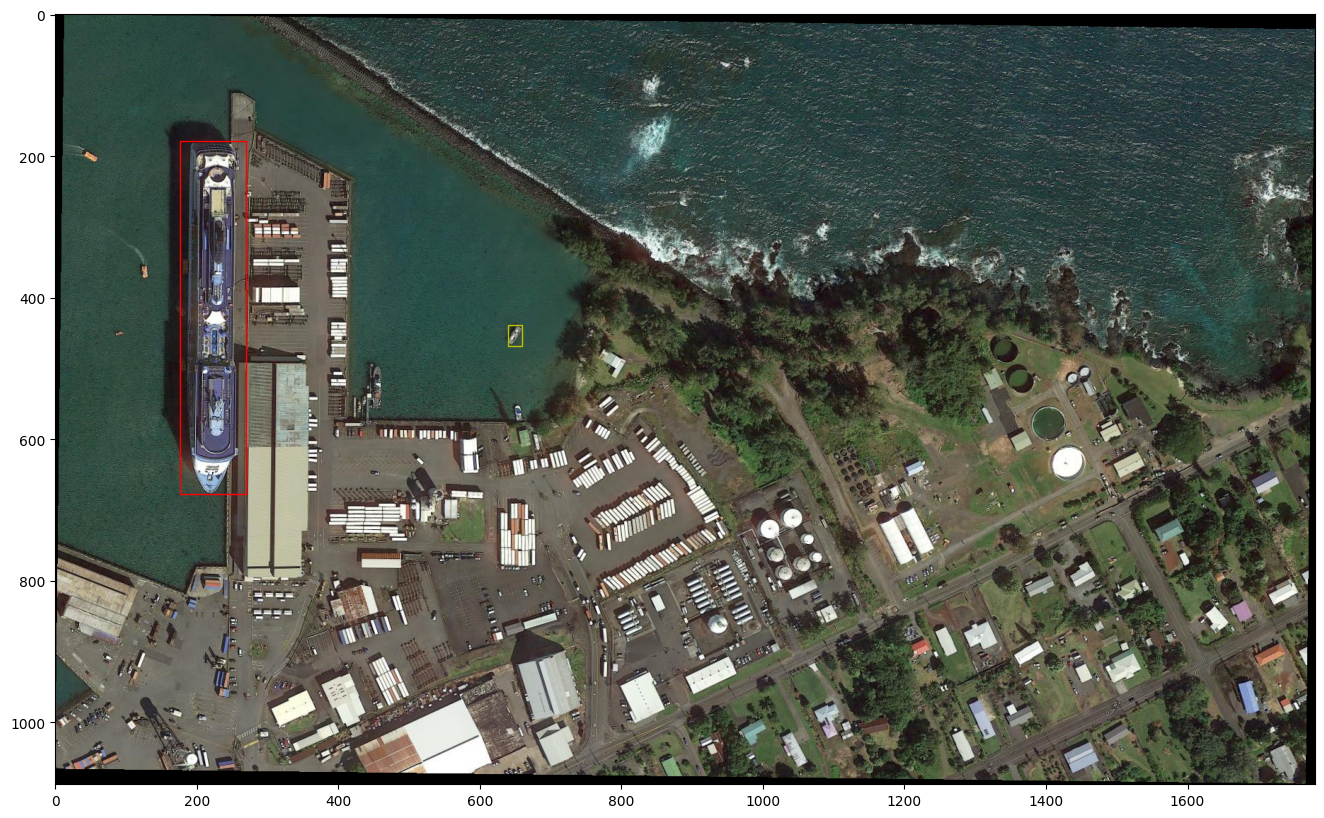

  0%|          | 1/385 [00:03<19:26,  3.04s/it]

1.png


  0%|          | 1/385 [00:08<53:16,  8.32s/it]


KeyboardInterrupt: 

In [4]:
plt.figure(figsize=(25,10))
Image.MAX_IMAGE_PIXELS=None
images = sorted(glob.glob("/workspace/notebooks/mmlabs/ship_org/test/*.png"))
imgs = []
annos = []
score_thr = 0.8
dict_file = {}
for image in tqdm.tqdm(images):

    img= Image.open(image)
    if len(img.size)==2:
        img=img.convert('RGB')
    im = np.array(img)
    result = inference_detector(model, im)
    pred_instances = result.pred_instances[
                result.pred_instances.scores > score_thr]
    bboxes= pred_instances["bboxes"].tolist()
    
    for w in range(len(bboxes)):
        
        xmin,ymin,xmax,ymax = bboxes[w] 
        xmin= int(xmin)
        xmax= int(xmax)
        ymin= int(ymin)
        ymax= int(ymax)
        w = xmax - xmin
        h = ymax - ymin

        if w > 200 or h > 200:
            rect=Rectangle((xmin,ymin),xmax-xmin , ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)

            
    files = crop_images(im)
    col = []
    for key,value in files.items():
        row = []
        for key1,value1 in value.items():

            file = files[key][key1]
            i=int(key)
            j=int(key1)
            try:
                result = inference_detector(model, file)
                pred_instances = result.pred_instances[
                            result.pred_instances.scores > score_thr]
                bboxes= pred_instances["bboxes"].tolist()

                for box in bboxes:

                    xmin,ymin,xmax,ymax = box
                    xmin= int(xmin + ((j)*640))
                    xmax= int(xmax + ((j)*640))
                    ymin= int(ymin + ((i)*640))
                    ymax= int(ymax + ((i)*640))
                    rect=Rectangle((xmin,ymin),xmax-xmin , ymax-ymin, linewidth=1, edgecolor='y', facecolor='none')
                    plt.gca().add_patch(rect)

            except:
                a=1
            row.append(file)
        rows = np.concatenate(row, axis=1)
        col.append(rows)
    im = np.concatenate(col, axis=0)  
    
    print(image.split('/')[-1])
    plt.imshow(im)
    plt.pause(0.05)